# Levy Stable models of Stochastic Volatility
- https://pyro.ai/examples/stable.html

In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoNormal, init_to_sample, init_to_median
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam, HaarReparam, LocScaleReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps

pyro.enable_validation(True)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23116])

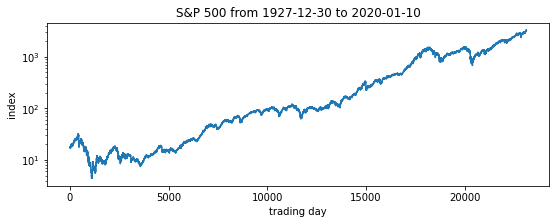

In [3]:
pyplot.figure(figsize=(9, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.ylabel("index")
pyplot.xlabel("trading day")
pyplot.title("S&P 500 from {} to {}".format(dates[0], dates[-1]));

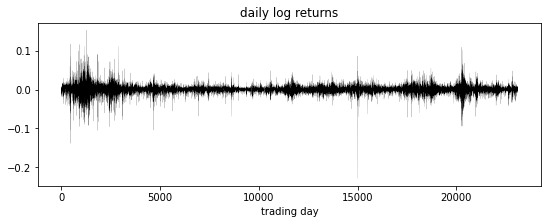

In [4]:
pyplot.figure(figsize=(9, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("daily log returns")
pyplot.xlabel("trading day");

Text(0.5, 1.0, 'Empirical distribution.  mean=0.000226, std=0.0119')

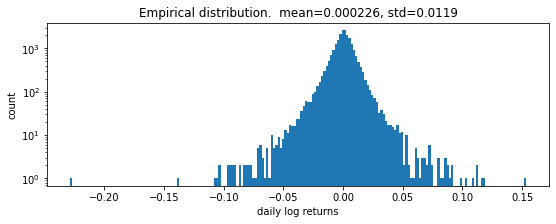

In [5]:
pyplot.figure(figsize=(9, 3))
pyplot.hist(r.numpy(), bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()))

In [6]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.961662292480469
step 20 loss = 4.850587844848633
step 40 loss = 1.5544664859771729
step 60 loss = 1.6165744066238403
step 80 loss = 1.537550449371338
step 100 loss = 1.3704826831817627
step 120 loss = 1.3326966762542725
step 140 loss = 1.2837563753128052
step 160 loss = 1.2797116041183472
step 180 loss = 1.2778178453445435
step 200 loss = 1.282110333442688
--------------------
loc = 0.0004461
scale = 0.008593
stability = 1.977
CPU times: user 2.06 s, sys: 419 ms, total: 2.48 s
Wall time: 1.92 s


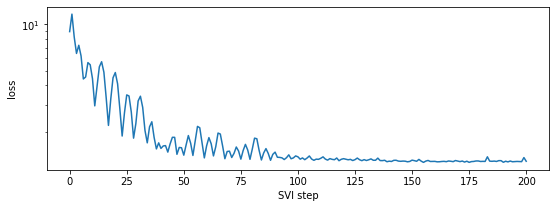

In [7]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

print("-" * 20)
pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.yscale("log")
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.squeeze().item()))

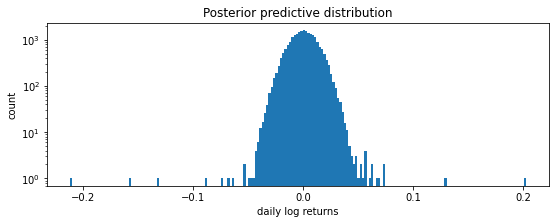

In [8]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(9, 3))
pyplot.hist(samples.numpy(), bins=200)
pyplot.yscale("log")
pyplot.xlabel("daily log returns")
pyplot.ylabel("count")
pyplot.title("Posterior predictive distribution");

# convert this part to forecasting model

In [10]:
class FModel(ForecastingModel):
    def model(self, zero_data, covariates):

        duration, data_dim = zero_data.size()
        event_dim = 2

        h_0_dist = dist.Normal(0., 1).expand(torch.Size([1, data_dim])).to_event(event_dim)
        h_0 = pyro.sample("h_0", h_0_dist)

        sigma_dist = dist.LogNormal(0, 1).expand(torch.Size([1, data_dim])).to_event(event_dim)
        sigma = pyro.sample("sigma", sigma_dist)

        with poutine.reparam(config={"v": DiscreteCosineReparam()}):
            v_dist = dist.Normal(0, 1).expand(torch.Size([duration])).to_event(1)
            v = pyro.sample("v",  v_dist).unsqueeze(-1)

        log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=0))
        sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

        # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
        r_loc_dist = dist.Normal(0, 1e-2).expand(torch.Size([1, data_dim])).to_event(event_dim)
        r_loc = pyro.sample("r_loc", r_loc_dist)

        r_skew_dist =  dist.Uniform(-1, 1).expand(torch.Size([1, data_dim])).to_event(event_dim)
        r_skew = pyro.sample("r_skew", r_skew_dist)

        r_stability_dist = dist.Uniform(1, 2).expand(torch.Size([1, data_dim])).to_event(event_dim)
        r_stability = pyro.sample("r_stability", r_stability_dist)

        with poutine.reparam(config={"r": StableReparam()}):
            r_dist = dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h).to_event(event_dim)
            prediction = pyro.sample("r", r_dist)     

        noise_dist = dist.Normal(0, .001).expand(torch.Size([duration, data_dim])).to_event(event_dim)
        self.predict(noise_dist, prediction)

In [11]:
model = FModel()
init_loc_fn = init_to_median
init_scale_fn = init_to_median
guide = AutoDiagonalNormal(model)
optim = ClippedAdam({"lr": 0.1, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps/5)})

num_steps = 3001
log_every = num_steps//10

holdout_size = 10
T2 = r.size(0)
T1 = T2 - holdout_size
returns = r.view(-1, 1)
covariates = torch.zeros(returns.size(-2), 0)

In [12]:
pyro.clear_param_store()

forecaster = Forecaster(model, returns[:T1], covariates[:T1], 
                        guide=guide, optim=optim,
                        num_steps=num_steps, log_every=log_every)

INFO 	 step    0 loss = 113525
INFO 	 step  300 loss = 42.7155
INFO 	 step  600 loss = 10.0491
INFO 	 step  900 loss = 2.08835
INFO 	 step 1200 loss = -0.879916
INFO 	 step 1500 loss = -2.05382
INFO 	 step 1800 loss = -2.56671
INFO 	 step 2100 loss = -2.82643
INFO 	 step 2400 loss = -2.96181
INFO 	 step 2700 loss = -3.02052
INFO 	 step 3000 loss = -3.05168


In [13]:
print("-" * 20)
for name, (lb, ub) in sorted(forecaster.guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.detach().squeeze().item()
        ub = ub.detach().squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

--------------------
h_0 = -1.384 ± 0.005223
r_loc = 0.04117 ± 0.003147
r_skew = 0.0001044 ± 0.0001045
r_stability = 1.972 ± 0.00128
sigma = 0.08929 ± 4.843e-05


In [14]:
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

In [25]:
target = returns[T1:T2].detach().numpy().reshape(-1)
preds = forecaster(returns[:T1], covariates[:T1+2], num_samples=50)
p10, p50, p90 = quantile(preds[:, 0], (0.325, 0.5, 0.675)).squeeze(-1).detach().numpy()

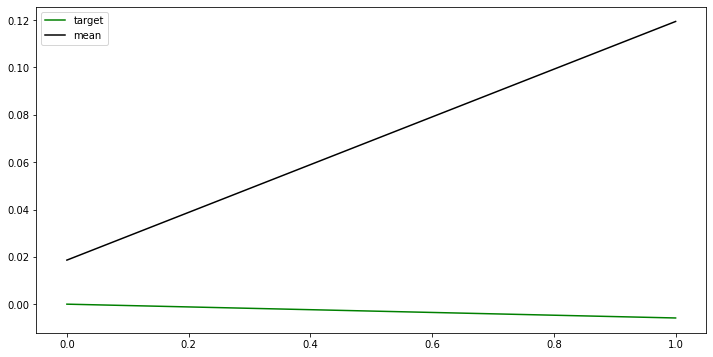

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(target[:2], "g", label="target")
ax.plot(p50, "black", label="mean")
# ax.plot(p10, "--r", alpha=0.5, label="-1 std")
# ax.plot(p90, "--b", alpha=0.5, label="+1 std")
ax.legend()

In [ ]:
a=torch.tensor([[1,1,1], [2,2,2]])

In [ ]:
a.cumsum(-1)

In [ ]:
a[0].cumsum(-1)

In [ ]:
import numpy as np

In [ ]:
a = 0.5
log_a = np.log(a)

In [ ]:
np.exp(log_a*0.5)

In [ ]:
a**(0.5)